------------------------------
# CNN from scratch
------------------------------

### 1.  Loading data and normalize pixel values

2023-05-13 21:14:57.075230: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 21:14:57.113470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 21:14:57.658757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


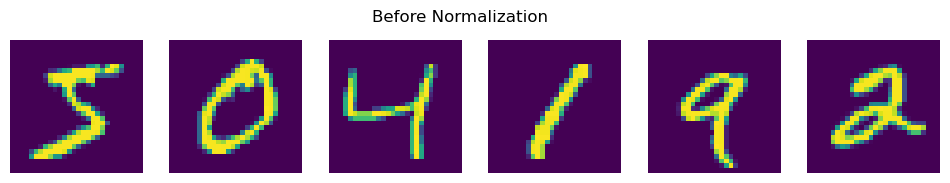

(60000, 784)


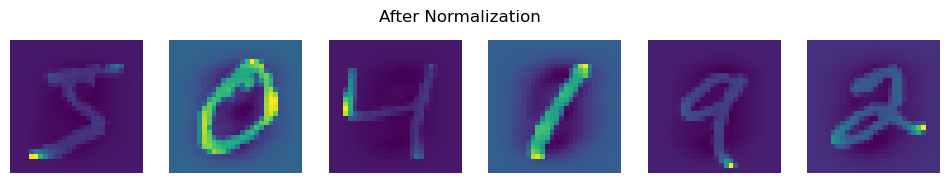

Number of categories:  10


In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# load the MNIST dataset
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()

# plot the first five images before normalization
plt.figure(figsize=(12,2))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(xTrain[i])
    plt.axis('off')
plt.suptitle('Before Normalization')
plt.show()


# Preprocess the data, alternative: but gives worse results
# xTrain = xTrain / 255
# xTest = xTest / 255


# normalizing with standard scalar: gives better result for the model
scaler = StandardScaler()
h, w = xTrain.shape[1], xTrain.shape[2]
xTrain = xTrain.reshape(-1, h * w)
xTest = xTest.reshape(-1, h * w)
print(xTrain.shape)

# fit it to the train and test
xTrain = scaler.fit_transform(xTrain)
xTrain = xTrain.reshape(-1, h, w)
xTest = scaler.transform(xTest)
xTest = xTest.reshape(-1, h, w)


# plot after normalization
plt.figure(figsize=(12,2))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(xTrain[i])
    plt.axis('off')
plt.suptitle('After Normalization')
plt.show()

# todo: remove
# xTrain = xTrain[:2000]
# yTrain = yTrain[:2000]
# xTest = xTest[:150]
# yTest = yTest[:150]

# applying one hot encoding
nUniqueLabels = len(np.unique(yTrain))
print("Number of categories: ",nUniqueLabels)
yEncoded = np.zeros((len(yTrain), nUniqueLabels))
for i, label in enumerate(yTrain):
    yEncoded[i, label] = 1
yTrain = yEncoded

yEncoded2 = np.zeros((len(yTest), nUniqueLabels))
for i, label in enumerate(yTest):
    yEncoded2[i, label] = 1
yTest = yEncoded2

----------------------------------
### 2. Convolution layer

In [2]:
# nK: Number of kernels
class ConvLayer:
    def __init__(self, nK=2, kDim=3):
        self.nK = nK
        self.kDim = kDim # 3 * 3
        self.previnM = None
        self.kernels = np.random.randn(nK, kDim, kDim)
        # print("KernelShape: ", self.kernels.shape)

    # multiply a 2d matrix by kenel, sliding across
    def convolute(self, inM, kernel):
        km, kn = kernel.shape
        m = inM.shape[0] - km + 1
        n = inM.shape[1] - kn + 1
        outM = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                outM[i, j] = np.sum(inM[i:i+km, j:j+kn] * kernel)

        return outM
    
    # forward prop
    def forward(self, inM):
        # store for backpropagation
        self.previnM = inM

        # compute shapes
        h = inM.shape[0] - self.kDim + 1
        w = inM.shape[1] - self.kDim + 1
        convOut = np.zeros((h, w, self.nK))

        # for each kernel
        for i in range(self.nK):
            # apply the i-th kernel to the inM image
            convolved = self.convolute(inM, self.kernels[i])
            
            # store the result in the convOut matrix
            for hi in range(h):
                for wi in range(w):
                    convOut[hi, wi, i] = convolved[hi, wi]

        # print("C: ", convOut.shape)
        return convOut
    
    # back prop: equation solution found online
    def backward(self, dO, lr):
        
        dK = np.zeros(self.kernels.shape)
        # self.kernels.shape # 2,3,3

        # for each kernel 
        for i in range(self.nK):
            dK[i] = self.convolute(self.previnM, dO[:, :, i])

        # update the kernels
        self.kernels -= lr * dK
        return None

----------------------------------
### 3. Average pooling layer

In [3]:
# avg pool layer, poolsize = stride
class AvgPoolingLayer:
    def __init__(self, pS=2):
        self.pS = pS
        self.prevIn = None

    #forwar prop
    def forward(self, inM):
        self.prevIn = inM   # remember the input matrix
        m, n, o = inM.shape
        outM = np.zeros((int(m / self.pS), int(n/ self.pS), o))

        # take mean of the pool size
        for i in range(0, m, self.pS):
            for j in range(0, n, self.pS):
                outM[int(i / self.pS), int(j / self.pS)] = np.mean(inM[i:i + self.pS, j:j + self.pS], axis=(0, 1))

        # print("A: ", outM.shape)
        return outM
    
    # back prop
    def backward(self, dO):
        outM = np.zeros(self.prevIn.shape)

        #upscale
        for i in range(0, outM.shape[0], self.pS):
            for j in range(0, outM.shape[1], self.pS):
                for k in range(self.pS):
                    for l in range(self.pS):
                        outM[i + k, j + l] = dO[int(i / self.pS), int(j / self.pS)] / (self.pS * self.pS)
        # print("B-A: ", outM.shape)
        return outM


----------------------------------
### 4. 1*1 convolution layer: fully connected

In [4]:
class FullyConnectedLayer:
    def __init__(self, inNeurons, outNeurons):
        # weights for each of the neurons in the flattened layer, He initialization method
        self.w = np.random.randn(inNeurons, outNeurons) * np.sqrt(2 / inNeurons)
        self.b = np.zeros(outNeurons)
        self.inShape = None
        self.lastIn = None

    # forward prop
    def forward(self, inLayer):
        # store shape for backprop
        self.inShape = inLayer.shape
        inLayerFlat = inLayer.flatten()
        # print("Iflat:", inLayerFlat.shape)
        self.lastIn = inLayerFlat
        return np.dot(inLayerFlat, self.w) + self.b
    
    # backward prop
    def backward(self, dO, lr):
        # dO is (10,)
        outMat = np.dot(dO, self.w.T).reshape(self.inShape)
        dW = np.dot(self.lastIn.reshape(-1, 1), dO.reshape(1, -1))
        dB = dO

        # update weights and biases
        self.w -= lr * dW
        self.b -= lr * dB
        # print("B-F: ",outMat.shape)
        return outMat

--------------------------
### 5. CNN class

In [5]:
class CNN:
    def __init__(self, actFnName = 'sigmoid'):
        self.conv1 = ConvLayer()
        self.pool1 = AvgPoolingLayer()
        self.fc1 = FullyConnectedLayer(13 * 13 * 2, 10)
        self.lastConvActVal = None
        self.actFn = None
        self.actFnDeriv = None

        # define activation functions to be used with the first convolution layer
        if actFnName == 'relu':
            self.actFn = self.relu
            self.actFnDeriv = self.reluDeriv
        elif actFnName == 'sigmoid':
            self.actFn = self.sigmoid
            self.actFnDeriv = self.sigmoidDeriv
        elif actFnName == 'tanh':
            self.actFn = self.tanh
            self.actFnDeriv = self.tanhDeriv

    # softmax
    def softmax(self, x):
        eX = np.exp(x - np.max(x))
        return eX / eX.sum(axis=-1, keepdims=True)

    # sigmoid function and its derivative
    def sigmoid(self,x):
        return (1/(1+np.exp(-x)))
    def sigmoidDeriv(self, x):
        s = self.sigmoid(x)
        return s * (1 -s)
    
    # hyperbolic tangent and its derivative 
    def tanh(self, x):
        return np.tanh(x)
    def tanhDeriv(self,x):
        t = np.tanh(x)
        return 1 - t ** 2
    
    # relu function and its derivative
    def relu(self, x):
        return x * (x > 0)
    def reluDeriv(self, x):
        return 1. * (x>0)
    
    # forward prop
    def forward(self, input):
        layerRes = self.conv1.forward(input)
        self.lastConvActVal = self.actFn(layerRes)
        layerRes = self.pool1.forward(self.lastConvActVal)
        layerRes = self.fc1.forward(layerRes)
        layerRes = self.softmax(layerRes)
        return layerRes
    
    # backward prop
    def backward(self, dLoss, lr):
        dLoss = self.fc1.backward(dLoss, lr)
        dLoss = self.pool1.backward(dLoss)
        dLoss *= self.actFnDeriv(self.lastConvActVal)
        self.conv1.backward(dLoss, lr)

    # train the model
    def train(self, xTrain, yTrain, xt, yt, lr, epochs):
        for epoch in range(epochs):
            # print("Epoch:" , epoch)
            loss = 0
            accuracy = 0
            for i, (x, y) in enumerate(zip(xTrain, yTrain)):
                yP = self.forward(x)
                # categorical cross-entropy loss
                loss += -np.sum(y * np.log(yP))
                accuracy += np.argmax(yP) == np.argmax(y)
                # categorical loss derivative wrt to softmax ie. gradient of the loss with respect to the output of the softmax layer
                dLoss = yP - y
                self.backward(dLoss, lr)
                # sys.exit()
            loss /= len(xTrain)
            accuracy /= len(xTrain)
            print(f'Epoch: {epoch + 1}, Train: Loss: {loss:.4f}, Accuracy: {accuracy:.4f} |', end=" ")
            self.test(xt, yt)

    #test the model with test data
    def test(self, xT, yT):
        loss = 0
        accuracy = 0
        n = len(xT)
        for x, y in zip(xT, yT):
            yP = self.forward(x)
            # categorical cross-entropy loss
            loss += -np.sum(y * np.log(yP))
            accuracy += np.argmax(yP) == np.argmax(y)
        loss /= n
        accuracy /= n
        print(f'Test: Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


-------------------------
### 6. Training and testing with different activation functions

In [6]:
# train and test with sigmoid
cnn = CNN(actFnName = 'sigmoid')
cnn.train(xTrain, yTrain, xTest, yTest, lr=0.005, epochs=5)
cnn.test(xTest, yTest)

Epoch: 1, Train: Loss: 0.3980, Accuracy: 0.8857 | Test: Loss: 0.3216, Accuracy: 0.9046
Epoch: 2, Train: Loss: 0.3049, Accuracy: 0.9097 | Test: Loss: 0.3102, Accuracy: 0.9084
Epoch: 3, Train: Loss: 0.2943, Accuracy: 0.9130 | Test: Loss: 0.3067, Accuracy: 0.9094
Epoch: 4, Train: Loss: 0.2892, Accuracy: 0.9146 | Test: Loss: 0.3051, Accuracy: 0.9099
Epoch: 5, Train: Loss: 0.2861, Accuracy: 0.9156 | Test: Loss: 0.3041, Accuracy: 0.9105
Test: Loss: 0.3041, Accuracy: 0.9105


In [7]:
# test with tanh
cnn2 = CNN(actFnName = 'tanh')
cnn2.train(xTrain, yTrain, xTest, yTest, lr=0.005, epochs=5)
cnn2.test(xTest, yTest)

Epoch: 1, Train: Loss: 0.3443, Accuracy: 0.8982 | Test: Loss: 0.3455, Accuracy: 0.8971
Epoch: 2, Train: Loss: 0.2940, Accuracy: 0.9142 | Test: Loss: 0.3351, Accuracy: 0.9027
Epoch: 3, Train: Loss: 0.2833, Accuracy: 0.9176 | Test: Loss: 0.3279, Accuracy: 0.9056
Epoch: 4, Train: Loss: 0.2762, Accuracy: 0.9200 | Test: Loss: 0.3213, Accuracy: 0.9090
Epoch: 5, Train: Loss: 0.2704, Accuracy: 0.9217 | Test: Loss: 0.3157, Accuracy: 0.9107
Test: Loss: 0.3157, Accuracy: 0.9107


In [8]:
# test with relu
cnn3 = CNN(actFnName = 'relu')
cnn3.train(xTrain, yTrain, xTest, yTest, lr=0.005, epochs=5)
cnn3.test(xTest, yTest)

Epoch: 1, Train: Loss: 0.2651, Accuracy: 0.9248 | Test: Loss: 0.2373, Accuracy: 0.9349
Epoch: 2, Train: Loss: 0.1747, Accuracy: 0.9514 | Test: Loss: 0.1666, Accuracy: 0.9522
Epoch: 3, Train: Loss: 0.1514, Accuracy: 0.9567 | Test: Loss: 0.1595, Accuracy: 0.9542
Epoch: 4, Train: Loss: 0.1416, Accuracy: 0.9594 | Test: Loss: 0.1582, Accuracy: 0.9564
Epoch: 5, Train: Loss: 0.1351, Accuracy: 0.9604 | Test: Loss: 0.1501, Accuracy: 0.9576
Test: Loss: 0.1501, Accuracy: 0.9576


-------------------------
References:

1. Convolution back propagation math:
https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c

2. Gradient of the loss with respect to output of the softmax layer:
https://stats.stackexchange.com/questions/370723/how-to-calculate-the-derivative-of-crossentropy-error-function